 DOWNSAMPLING - PREDICTING SPAM EMAILS

#Imports/Helper functions

In [ ]:
# basic imports
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from datetime import datetime
%matplotlib inline

# data processing 
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# get predictions from the best perfomming model
from sklearn.metrics import accuracy_score , confusion_matrix , f1_score ,roc_auc_score
from sklearn.metrics import precision_score , recall_score , roc_curve


# text processing
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.tokenize import word_tokenize 


# deep learning libraries
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, Masking

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# function to draw graph results for the model
def plot_performance(history , Model_name):
    fig , ax = plt.subplots(1,2 , figsize =(12 ,6))
    ax[0].set_title(f"Accuracy Perfomance Analysis for {Model_name}" , c='red')
    ax[1].set_title(f"Loss Perfomance Analysis for {Model_name}" , c='red')
    ax[0].plot(history.history['acc'] , label ='train accuracy' , c='g')
    ax[0].plot(history.history['val_acc'] , label ='val accuracy' , c='orange')
    ax[1].set_ylabel('Accuracy' , fontsize =15)
    ax[1].set_xlabel('epochs' , fontsize =15)
    ax[1].plot(history.history['loss'] , label ='train loss' , c ='yellow')
    ax[1].plot(history.history['val_loss'] , label ='val loss' , c ='red')
    ax[1].set_ylabel('Loss' , fontsize =15)
    ax[1].set_xlabel('epoch' , fontsize =15)
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')

In [ ]:
def evaluate_model_performance(model_name, test_set):
     
    preds_probs = model_name.predict(test_set)
    #evaluate the real class labels
    preds_labels= [1 if x>=0.5 else 0 for x in preds_probs]

    actual_labels =y_test
    print(f"\n*****Evaluating {type} Models Score using various metrics************\n")
    print(f"\t\tAccuracy is  {accuracy_score(actual_labels , preds_labels)}")
    print(f"\t\tPrecision Score is  {precision_score(actual_labels , preds_labels)}")
    print(f"\t\tRecall Score is  {recall_score(actual_labels , preds_labels)}")
    print(f"\t\tF1 Score is  {f1_score(actual_labels , preds_labels)}\n\n\n")


    # draw confusion matrix to show results
    c_matrix1 = confusion_matrix(actual_labels , preds_labels)
    sns.heatmap(c_matrix1 , annot= True , annot_kws={"size": 10} ,fmt="")
    plt.title("Confusion matrix")
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")


In [ ]:
def plot_graphs(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

In [ ]:
def lemma(input_string):
  lemma_word = []
  word_tokens = word_tokenize(input_string)
  for w in word_tokens:
    w1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
    w2 = wordnet_lemmatizer.lemmatize(w1, pos = "v")
    w3 = wordnet_lemmatizer.lemmatize(w2, pos = "a")
    lemma_word.append(w3)
  joined_string = ' '.join(lemma_word)
  return joined_string

In [ ]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_string):
  lowercase = tf.strings.lower(input_string)
  no_punctuations = tf.strings.regex_replace(lowercase, r'[^\w\s]', ' ')
  no_stop = no_punctuations
  for stopwords in stop:
    no_stop = tf.strings.regex_replace(no_stop, ' '+stopwords+' ', ' ')
  return no_stop

# Retrieving the dataset and converting it to a dataframe

In [ ]:
url = 'https://raw.githubusercontent.com/Taiga83/Spam-Detection-Project/main/SMSSpamCollection'
messages = pd.read_csv(url, sep='\t', names=['Label', 'Message'])
messages.groupby('Label').describe()

Message                                                               
        count unique                                                top freq
Label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

#

In [ ]:
# Get all the ham and spam text
ham = messages[messages.Label =='ham']
spam = messages[messages.Label =='spam']
# Convert to string
ham_string = " ".join(ham.Message.to_numpy().tolist())
spam_string = " ".join(spam.Message.to_numpy().tolist())

#Dataset visualization

##Ham wordcloud

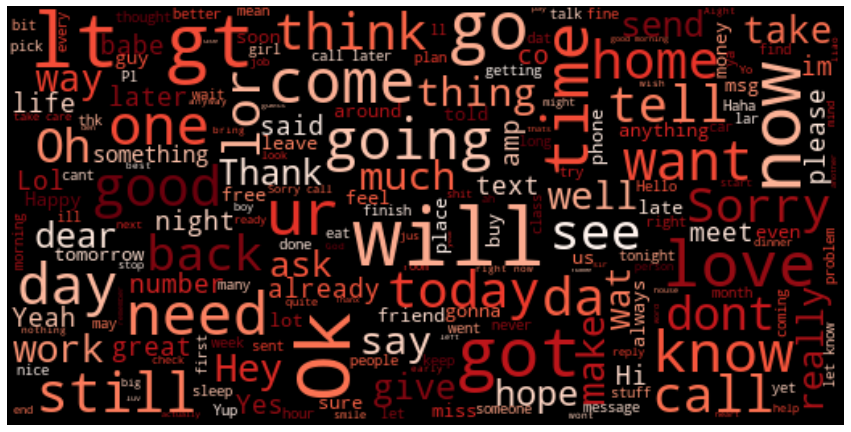

In [ ]:
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Reds').generate(ham_string)
plt.figure(figsize=(15,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##Spam wordcloud

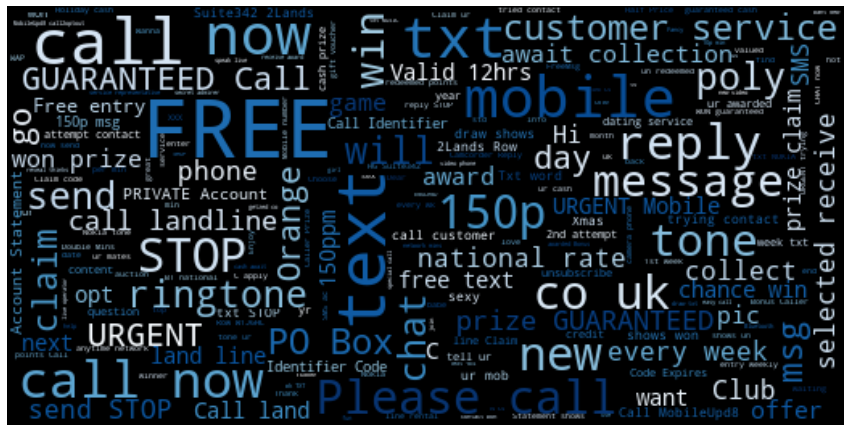

In [ ]:
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_string)
plt.figure(figsize=(15,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

##View split between ham and spam

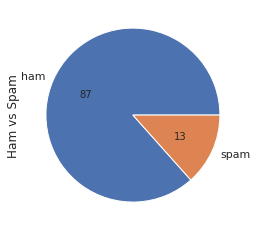

In [ ]:
messages.groupby('Label').size().plot(kind='pie', y='Label', label='Ham vs Spam', autopct='%.0f')

# Dense model with downsampling

## Data preprocessing

### Rebalancing data 

In [ ]:
now = datetime.now()
ham_downsample = resample(ham,
             replace=True,
             n_samples=len(spam),
             random_state=42)

print(ham_downsample.shape)
print(spam.shape)

(747, 2)
(747, 2)


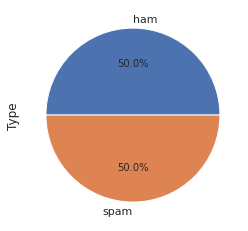

In [ ]:
data_downsampled = pd.concat([ham_downsample, spam])


data_downsampled.groupby('Label').size().plot(kind='pie',
                                       y = "Label",
                                       label = "Type",
                                       autopct='%1.1f%%')

Combine Data after Downsampling

In [ ]:
frames = [spam, ham_downsample]
combined_df = pd.concat(frames)
lengths = combined_df['Message'].apply(len)
avg_len = int(lengths.mean())
print(combined_df.describe())
print(f'Average number of characters = {avg_len}')

       Label                 Message
count   1494                    1494
unique     2                    1334
top     spam  Sorry, I'll call later
freq     747                       5
Average number of characters = 105


### Lemmamization

In [ ]:
combined_df['Message'] = combined_df['Message'].apply(lemma)

### Vectorization/split

In [ ]:
now = datetime.now()
combined_df['nLabel'] = combined_df['Label'].map({'spam': 0, 'ham': 1})
x_train, x_test, y_train, y_test = train_test_split(combined_df['Message'], combined_df['nLabel'], test_size=0.2, random_state=now.hour + now.minute + now.second)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=now.hour + now.minute + now.second)

In [ ]:
print(f'{(x_train.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for training')
print(f'{(x_test.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for testing')
print(f'{(x_val.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for validation')

75.97054886211512% of the dataset is being used for training
20.01338688085676% of the dataset is being used for testing
4.016064257028113% of the dataset is being used for validation


Vectorizing and Padding

In [ ]:
max_vocab = 1000
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab)
vectorize_layer.adapt(combined_df['Message'].to_numpy())

## Model training and evaluation

Sequential Model

In [ ]:
embedding_dim = 16
drop_value = 0.2 
n_dense = 24

In [ ]:
model = tf.keras.models.Sequential()
model.add(vectorize_layer)
model.add(Embedding(max_vocab, embedding_dim))
model.add(Masking(mask_value=0))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          16000     
                                                                 
 masking (Masking)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
num_epochs = 25
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_val, y_val),callbacks=[early_stop], verbose=2)

Epoch 1/25
36/36 - 3s - loss: 0.6919 - accuracy: 0.5894 - val_loss: 0.6904 - val_accuracy: 0.6500 - 3s/epoch - 80ms/step
Epoch 2/25
36/36 - 0s - loss: 0.6907 - accuracy: 0.6414 - val_loss: 0.6885 - val_accuracy: 0.7833 - 245ms/epoch - 7ms/step
Epoch 3/25
36/36 - 0s - loss: 0.6888 - accuracy: 0.6925 - val_loss: 0.6860 - val_accuracy: 0.8000 - 198ms/epoch - 5ms/step
Epoch 4/25
36/36 - 0s - loss: 0.6868 - accuracy: 0.7339 - val_loss: 0.6828 - val_accuracy: 0.8333 - 149ms/epoch - 4ms/step
Epoch 5/25
36/36 - 0s - loss: 0.6844 - accuracy: 0.7286 - val_loss: 0.6794 - val_accuracy: 0.8500 - 196ms/epoch - 5ms/step
Epoch 6/25
36/36 - 0s - loss: 0.6814 - accuracy: 0.7709 - val_loss: 0.6757 - val_accuracy: 0.8833 - 151ms/epoch - 4ms/step
Epoch 7/25
36/36 - 0s - loss: 0.6782 - accuracy: 0.7806 - val_loss: 0.6717 - val_accuracy: 0.8833 - 154ms/epoch - 4ms/step
Epoch 8/25
36/36 - 0s - loss: 0.6743 - accuracy: 0.7912 - val_loss: 0.6670 - val_accuracy: 0.8833 - 138ms/epoch - 4ms/step
Epoch 9/25
36/36 -

In [ ]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

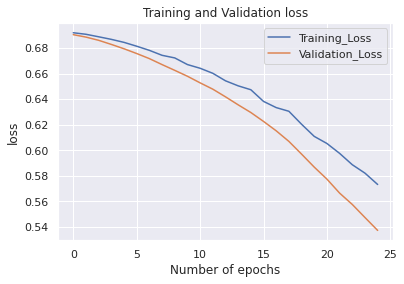

In [ ]:
plot_graphs('Training_Loss', 'Validation_Loss', 'loss')

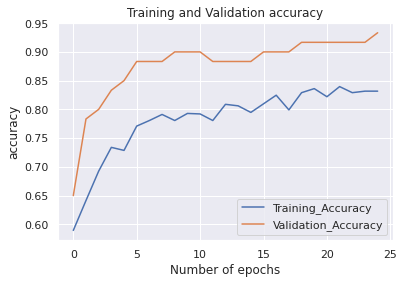

In [ ]:
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'accuracy')


*****Evaluating <class 'type'> Models Score using various metrics************

		Accuracy is  0.8996655518394648
		Precision Score is  0.9084967320261438
		Recall Score is  0.896774193548387
		F1 Score is  0.9025974025974025





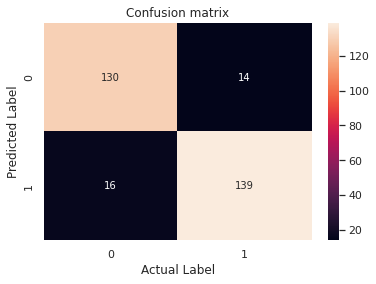

In [ ]:
evaluate_model_performance(model, x_test)

# LSTM model w/ downsampling

## Data preprocessing

### Rebalancing data 

In [ ]:
now = datetime.now()
ham_downsample = resample(ham,
             replace=True,
             n_samples=len(spam),
             random_state=42)

print(ham_downsample.shape)
print(spam.shape)

(747, 2)
(747, 2)


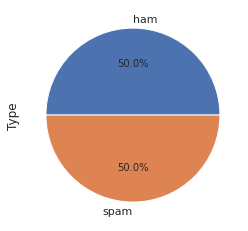

In [ ]:
data_downsampled = pd.concat([ham_downsample, spam])


data_downsampled.groupby('Label').size().plot(kind='pie',
                                       y = "Label",
                                       label = "Type",
                                       autopct='%1.1f%%')

Combine Data after Downsampling

In [ ]:
frames = [spam, ham_downsample]
combined_df = pd.concat(frames)
lengths = combined_df['Message'].apply(len)
avg_len = int(lengths.mean())
print(combined_df.describe())
print(f'Average number of characters = {avg_len}')

       Label                 Message
count   1494                    1494
unique     2                    1334
top     spam  Sorry, I'll call later
freq     747                       5
Average number of characters = 105


### Lemmamization

In [ ]:
combined_df['Message'] = combined_df['Message'].apply(lemma)

### Vectorization/Split

In [ ]:
now = datetime.now()
combined_df['nLabel'] = combined_df['Label'].map({'spam': 0, 'ham': 1})
x_train, x_test, y_train, y_test = train_test_split(combined_df['Message'], combined_df['nLabel'], test_size=0.2, random_state=now.hour + now.minute + now.second)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=now.hour + now.minute + now.second)

In [ ]:
print(f'{(x_train.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for training')
print(f'{(x_test.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for testing')
print(f'{(x_val.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for validation')

75.97054886211512% of the dataset is being used for training
20.01338688085676% of the dataset is being used for testing
4.016064257028113% of the dataset is being used for validation


Vectorizing and Padding

In [ ]:
max_vocab = 1000
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab)
vectorize_layer.adapt(combined_df['Message'].to_numpy())

## Model evaluation and training

In [ ]:
embedding_dim = 16
drop_value = 0.2 

In [ ]:
# define lstm model


lstm_model = tf.keras.models.Sequential()
#add embedding
# Embedding (input_dim: size of vocabolary, 
# output_dim: dimension of dense embedding, 
# input_length: length of input sequence)
lstm_model.add(vectorize_layer)
lstm_model.add(Embedding(input_dim=max_vocab, output_dim=embedding_dim))
lstm_model.add(Masking(mask_value=0))
lstm_model.add(LSTM(20, dropout=0.2, return_sequences=True))
lstm_model.add(LSTM(8))
lstm_model.add(Dense(1, activation='sigmoid'))
# check model summary
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 16)          16000     
                                                                 
 masking_1 (Masking)         (None, None, 16)          0         
                                                                 
 lstm (LSTM)                 (None, None, 20)          2960      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 928       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                      

In [ ]:
# compile the lstm model and train it
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])

# define callback for regulator
early_stopping = EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=10,
        mode='max')
    

lstm_history = lstm_model.fit(x_train, y_train, epochs=25, validation_data=(x_val, y_val),callbacks=[early_stopping], verbose=2)


Epoch 1/25
36/36 - 13s - loss: 0.6933 - acc: 0.4722 - val_loss: 0.6925 - val_acc: 0.5500 - 13s/epoch - 349ms/step
Epoch 2/25
36/36 - 2s - loss: 0.6923 - acc: 0.5022 - val_loss: 0.6920 - val_acc: 0.5500 - 2s/epoch - 50ms/step
Epoch 3/25
36/36 - 2s - loss: 0.6914 - acc: 0.5207 - val_loss: 0.6913 - val_acc: 0.5167 - 2s/epoch - 48ms/step
Epoch 4/25
36/36 - 2s - loss: 0.6893 - acc: 0.5612 - val_loss: 0.6896 - val_acc: 0.5167 - 2s/epoch - 43ms/step
Epoch 5/25
36/36 - 2s - loss: 0.6853 - acc: 0.6220 - val_loss: 0.6863 - val_acc: 0.5167 - 2s/epoch - 44ms/step
Epoch 6/25
36/36 - 2s - loss: 0.6798 - acc: 0.6203 - val_loss: 0.6772 - val_acc: 0.5167 - 2s/epoch - 44ms/step
Epoch 7/25
36/36 - 2s - loss: 0.6667 - acc: 0.6449 - val_loss: 0.6584 - val_acc: 0.5000 - 2s/epoch - 44ms/step
Epoch 8/25
36/36 - 2s - loss: 0.6443 - acc: 0.7004 - val_loss: 0.6245 - val_acc: 0.5833 - 2s/epoch - 45ms/step
Epoch 9/25
36/36 - 2s - loss: 0.6096 - acc: 0.7489 - val_loss: 0.5690 - val_acc: 0.7667 - 2s/epoch - 45ms/ste

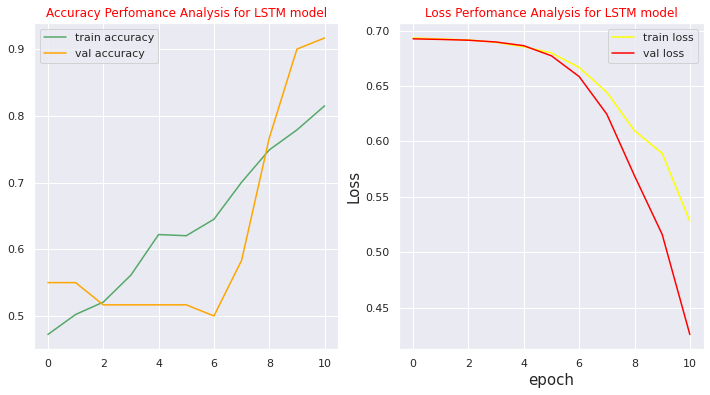

In [ ]:
# check the lstm model permomance 
plot_performance(lstm_history , "LSTM model")


*****Evaluating <class 'type'> Models Score using various metrics************

		Accuracy is  0.8461538461538461
		Precision Score is  0.831081081081081
		Recall Score is  0.8541666666666666
		F1 Score is  0.8424657534246575





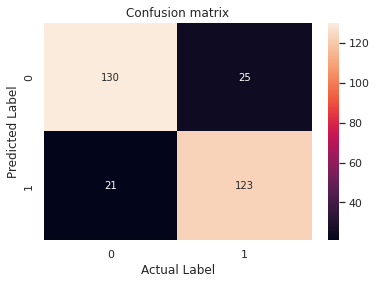

In [ ]:
evaluate_model_performance(lstm_model, x_test)

# BiLSTM model w/ downsampling

## Data preprocessing

### Rebalancing data 

In [ ]:
now = datetime.now()
ham_downsample = resample(ham,
             replace=True,
             n_samples=len(spam),
             random_state=42)

print(ham_downsample.shape)
print(spam.shape)

(747, 2)
(747, 2)


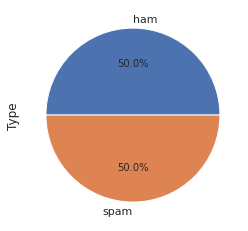

In [ ]:
data_downsampled = pd.concat([ham_downsample, spam])


data_downsampled.groupby('Label').size().plot(kind='pie',
                                       y = "Label",
                                       label = "Type",
                                       autopct='%1.1f%%')

Combine Data after Downsampling

In [ ]:
frames = [spam, ham_downsample]
combined_df = pd.concat(frames)
lengths = combined_df['Message'].apply(len)
avg_len = int(lengths.mean())
print(combined_df.describe())
print(f'Average number of characters = {avg_len}')

       Label                 Message
count   1494                    1494
unique     2                    1334
top     spam  Sorry, I'll call later
freq     747                       5
Average number of characters = 105


### Lemmamization

In [ ]:
combined_df['Message'] = combined_df['Message'].apply(lemma)

### Vectorization/Split

In [ ]:
now = datetime.now()
combined_df['nLabel'] = combined_df['Label'].map({'spam': 0, 'ham': 1})
x_train, x_test, y_train, y_test = train_test_split(combined_df['Message'], combined_df['nLabel'], test_size=0.2, random_state=now.hour + now.minute + now.second)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=now.hour + now.minute + now.second)

In [ ]:
print(f'{(x_train.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for training')
print(f'{(x_test.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for testing')
print(f'{(x_val.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for validation')

75.97054886211512% of the dataset is being used for training
20.01338688085676% of the dataset is being used for testing
4.016064257028113% of the dataset is being used for validation


Vectorizing and Padding

In [ ]:
max_vocab = 1000
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab)
vectorize_layer.adapt(combined_df['Message'].to_numpy())

## Model training and evaluation

In [ ]:
embedding_dim = 16
drop_value = 0.2 

In [ ]:
# define bidirectional LSTM  model

blstm_model = tf.keras.models.Sequential()
blstm_model.add(vectorize_layer)
blstm_model.add(Embedding(max_vocab, embedding_dim))
blstm_model.add(Masking(mask_value=0))
blstm_model.add(Bidirectional(LSTM(20, return_sequences=True)))
blstm_model.add(Bidirectional(LSTM(8)))
blstm_model.add(Dropout(drop_value))
blstm_model.add(Dense(1, activation='sigmoid'))
# check the blstm model summary

blstm_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, None, 16)          16000     
                                                                 
 masking_2 (Masking)         (None, None, 16)          0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 40)         5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               3136      
 nal)                                                            
                                                      

In [ ]:
# compile the blstm model and train it

blstm_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
blstm_history = blstm_model.fit(x_train, y_train, epochs=25, validation_data=(x_val, y_val),callbacks=[early_stopping], verbose=2)


Epoch 1/25
36/36 - 23s - loss: 0.6925 - acc: 0.4863 - val_loss: 0.6907 - val_acc: 0.5000 - 23s/epoch - 639ms/step
Epoch 2/25
36/36 - 2s - loss: 0.6900 - acc: 0.5233 - val_loss: 0.6876 - val_acc: 0.5333 - 2s/epoch - 65ms/step
Epoch 3/25
36/36 - 3s - loss: 0.6867 - acc: 0.5692 - val_loss: 0.6821 - val_acc: 0.5833 - 3s/epoch - 71ms/step
Epoch 4/25
36/36 - 2s - loss: 0.6798 - acc: 0.6106 - val_loss: 0.6712 - val_acc: 0.6500 - 2s/epoch - 67ms/step
Epoch 5/25
36/36 - 2s - loss: 0.6615 - acc: 0.6626 - val_loss: 0.6436 - val_acc: 0.7000 - 2s/epoch - 67ms/step
Epoch 6/25
36/36 - 3s - loss: 0.6284 - acc: 0.7242 - val_loss: 0.6013 - val_acc: 0.8000 - 3s/epoch - 72ms/step
Epoch 7/25
36/36 - 3s - loss: 0.5923 - acc: 0.7436 - val_loss: 0.5659 - val_acc: 0.8333 - 3s/epoch - 72ms/step
Epoch 8/25
36/36 - 3s - loss: 0.5686 - acc: 0.7841 - val_loss: 0.5350 - val_acc: 0.8667 - 3s/epoch - 71ms/step
Epoch 9/25
36/36 - 2s - loss: 0.5318 - acc: 0.8009 - val_loss: 0.4973 - val_acc: 0.8667 - 2s/epoch - 67ms/ste

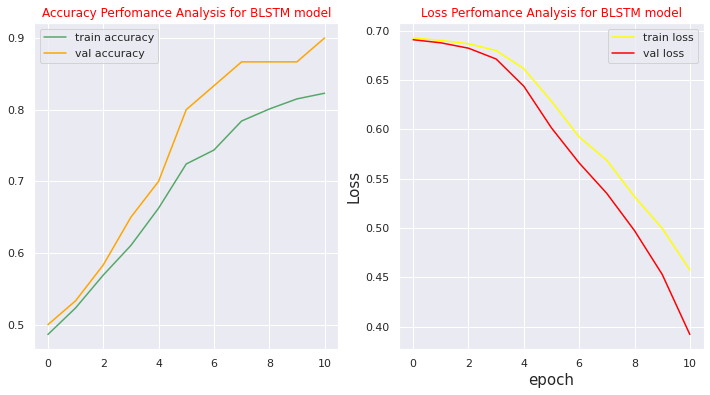

In [ ]:
# plot accuracy and losses summary
plot_performance(blstm_history , "BLSTM model")


*****Evaluating <class 'type'> Models Score using various metrics************

		Accuracy is  0.8561872909698997
		Precision Score is  0.8590604026845637
		Recall Score is  0.8533333333333334
		F1 Score is  0.8561872909698997





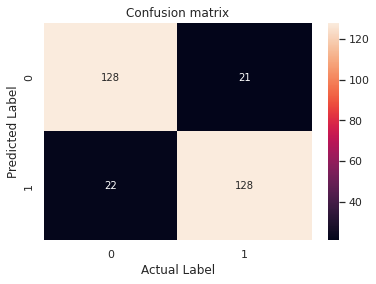

In [ ]:
# check evaluation summary
evaluate_model_performance(blstm_model, x_test)